In [1]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
import io
import sklearn.tree as tree
import matplotlib.pyplot as plt
import graphviz
import pydotplus
import seaborn as sns
import numpy as np
%matplotlib inline

##1. Data Load

We are going to use 'Titanic data' again

(The data is already preprocessed)

In [7]:
# Upload the Titanic dataset
uploaded = files.upload()

Saving test-1.csv to test-1 (1).csv
Saving train-1.csv to train-1 (2).csv


In [8]:
train = pd.read_csv(io.BytesIO(uploaded['train-1.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test-1.csv']))

In [9]:
train.loc[train['Sex'] == 'male', 'Sex'] = 0
train.loc[train['Sex'] == 'female', 'Sex'] = 1
train.loc[train['Embarked'] == 'S', 'Embarked'] = 0
train.loc[train['Embarked'] == 'Q', 'Embarked'] = 1
train.loc[train['Embarked'] == 'C', 'Embarked'] = 2

test.loc[test['Sex'] == 'male', 'Sex'] = 0
test.loc[test['Sex'] == 'female', 'Sex'] = 1
test.loc[test['Embarked'] == 'S', 'Embarked'] = 0
test.loc[test['Embarked'] == 'Q', 'Embarked'] = 1
test.loc[test['Embarked'] == 'C', 'Embarked'] = 2

In [10]:
train_x, train_y = train.drop(columns = ['Survived']), train['Survived']
test_x, test_y = test.drop(columns = ['Survived']), test['Survived']

####Feature information####

For x

Pclass - 1, 2, 3 \
Sex - 0(male), 1(female)\
Age - float\
SibSp - int(# of brothers and sisters or spouse)\
Parch - int, (# of parents or children)\
Fare - float\
Embarked - 0, 1, 2(boarding place)

For y
Survived - 0(death), 1(survival)


In [11]:
train_x.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,32.0,0,0,7.9250,0
1,1,0,40.0,0,0,31.0000,2
2,3,0,28.0,0,0,7.7958,0
3,1,1,19.0,1,0,91.0792,2
4,3,0,24.0,0,0,7.7958,0


In [12]:
train_y

0      0
1      1
2      0
3      1
4      0
      ..
618    1
619    0
620    0
621    0
622    0
Name: Survived, Length: 623, dtype: int64

In [13]:
#Number of data
print(f'Train data: {len(train)}\nTest data: {len(test)}')

Train data: 623
Test data: 268


##2. Decision Tree##


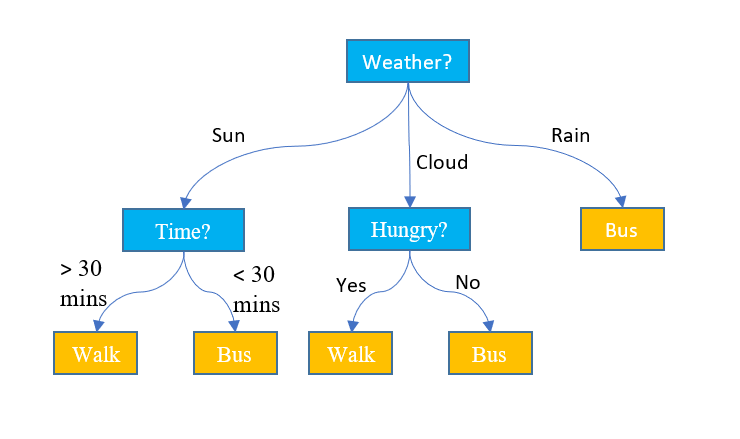

*reference url: https://scikit-learn.org/stable/modules/tree.html

In [14]:
result_dict = dict()

####*Predefined function for visualizing the decision tree model

visualize_decision_tree(model, figure_size) \
feature_importances(model) \
visualize_boundary(model, x, y, feature1, feature2) 

In [25]:
#Function for visualizing decision tree

def visualize_decision_tree(model, figure_size):
  size = f"{figure_size[0]},{figure_size[1]}!"
  dot_data = tree.export_graphviz(model, out_file=None, class_names=['Unsurvived', 'Survived'] , \
  feature_names = list(train_x.columns), impurity=False, filled=True)
  pydot_graph = pydotplus.graph_from_dot_data(dot_data)
  pydot_graph.write_png('original_tree.png')
  pydot_graph.set_size(f'{size}')
  pydot_graph.write_png('resized_tree.png')
  gvz_graph = graphviz.Source(pydot_graph.to_string())
  return gvz_graph

In [16]:
#Function for visualizing feature importance of decision tree
def feature_importances(model):
  print("Feature importances:\n{0}".format(np.round(model.feature_importances_, 3)))
  for name, value in zip(train_x.columns , model.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
  sns.barplot(x=model.feature_importances_ , y=train_x.columns)

In [17]:
#Function for visualizing decision boundart of decision tree
#This function do learning the model for two features.
def visualize_boundary(model, x, y, feature1, feature2, ensemble = False):
  x = x[[feature1, feature2]]
  for feature in (feature1, feature2):
    q1=x[feature].quantile(0.25)
    q3=x[feature].quantile(0.75)
    iqr=q3-q1

    condition=x[feature]>q3+1.5*iqr
    outlier=x[condition].index
    x.drop(outlier,inplace=True)
    y = y.drop(outlier)
  x = (x- x.mean())/x.std()
  fig,ax = plt.subplots()
  ax.scatter(x[[feature1]], x[[feature2]], c=y, s=25, cmap='rainbow', edgecolor='k',
              clim=(y.min(), y.max()), zorder=2)
  ax.axis('tight')
  ax.axis('off')
  xlim_start , xlim_end = ax.get_xlim()
  ylim_start , ylim_end = ax.get_ylim()
  model.fit(x, y)
  xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
                          levels=np.arange(n_classes + 1) - 0.5,
                          cmap='rainbow', clim=(y.min(), y.max()),
                          zorder=1)

###2-1. Decision tree with no depth limit ###

In [18]:
#Implement example decision tree(No depth limit)
example_tree = tree.DecisionTreeClassifier()
#Train the model
example_tree.fit(train_x, train_y)

DecisionTreeClassifier()

In [19]:
train_acc = example_tree.score(train_x, train_y)
test_acc = example_tree.score(test_x, test_y)
print(f'Train Acc: {train_acc}\nTest Acc: {test_acc}')

Train Acc: 0.985553772070626
Test Acc: 0.7649253731343284


In [20]:
#Save the result of model in result_dict
result_dict['Nodepth'] = (train_acc, test_acc)

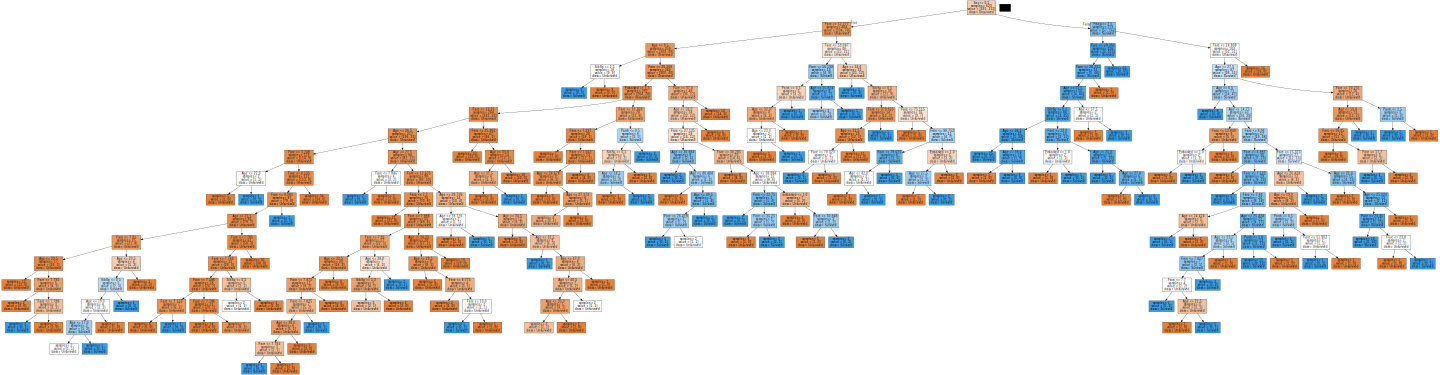

In [21]:
#Visualize the decision tree
visualize_decision_tree(model = example_tree, figure_size = (20, 20))

Feature importances:
[0.083 0.326 0.221 0.045 0.021 0.285 0.019]
Pclass : 0.083
Sex : 0.326
Age : 0.221
SibSp : 0.045
Parch : 0.021
Fare : 0.285
Embarked : 0.019


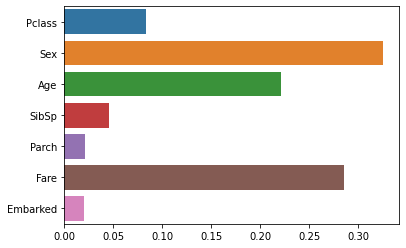

In [22]:
#Visualize the decision tree
feature_importances(example_tree)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'clim'


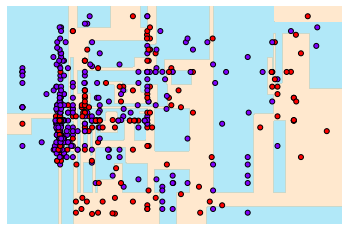

In [23]:
#Visualize decision boundary
#Use the first and second important feature expect for sex(because it is one-hot-vector dat)
#Blue is death, red is survival
visualize_boundary(model=example_tree, x=train_x, y=train_y, feature1="Fare", feature2='Age')

###2-2. Decision Tree with depth limit

###Problem 1(10pt)###

1. Implement the decision tree with 4 depth limit
2. Check the acc of train and test data
3. Save that result to result dict 
4. Visualize the decision tree, feature imfortance, decision boundart

Train Acc: 0.8651685393258427
Test Acc: 0.7910447761194029


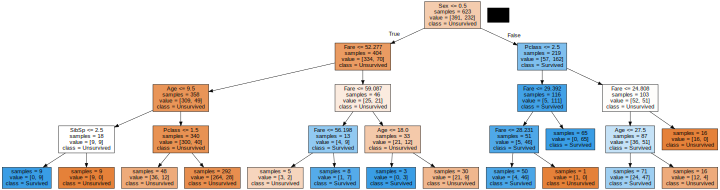

In [96]:
# 1)
example_tree = tree.DecisionTreeClassifier(max_depth=4)
#Train the model
example_tree.fit(train_x, train_y)

# 2)
train_acc = example_tree.score(train_x, train_y)
test_acc = example_tree.score(test_x, test_y)
print(f'Train Acc: {train_acc}\nTest Acc: {test_acc}')

# 3)
result_dict['depth'] = (train_acc, test_acc)

# 4)
visualize_decision_tree(model = example_tree, figure_size = (10, 10))

Feature importances:
[0.145 0.567 0.075 0.056 0.    0.157 0.   ]
Pclass : 0.145
Sex : 0.567
Age : 0.075
SibSp : 0.056
Parch : 0.000
Fare : 0.157
Embarked : 0.000


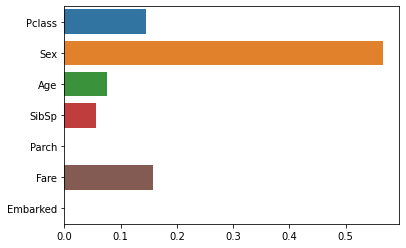

In [46]:
#Function for visualizing feature importance of decision tree
def feature_importances(model):
  print("Feature importances:\n{0}".format(np.round(model.feature_importances_, 3)))
  for name, value in zip(train_x.columns , model.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
  sns.barplot(x=model.feature_importances_ , y=train_x.columns)

feature_importances(example_tree)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'clim'


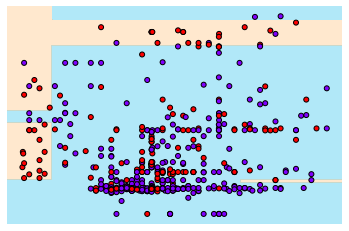

In [52]:
visualize_boundary(model=example_tree, x=train_x, y=train_y, feature1="Age", feature2='Fare')

##3. Ensemble

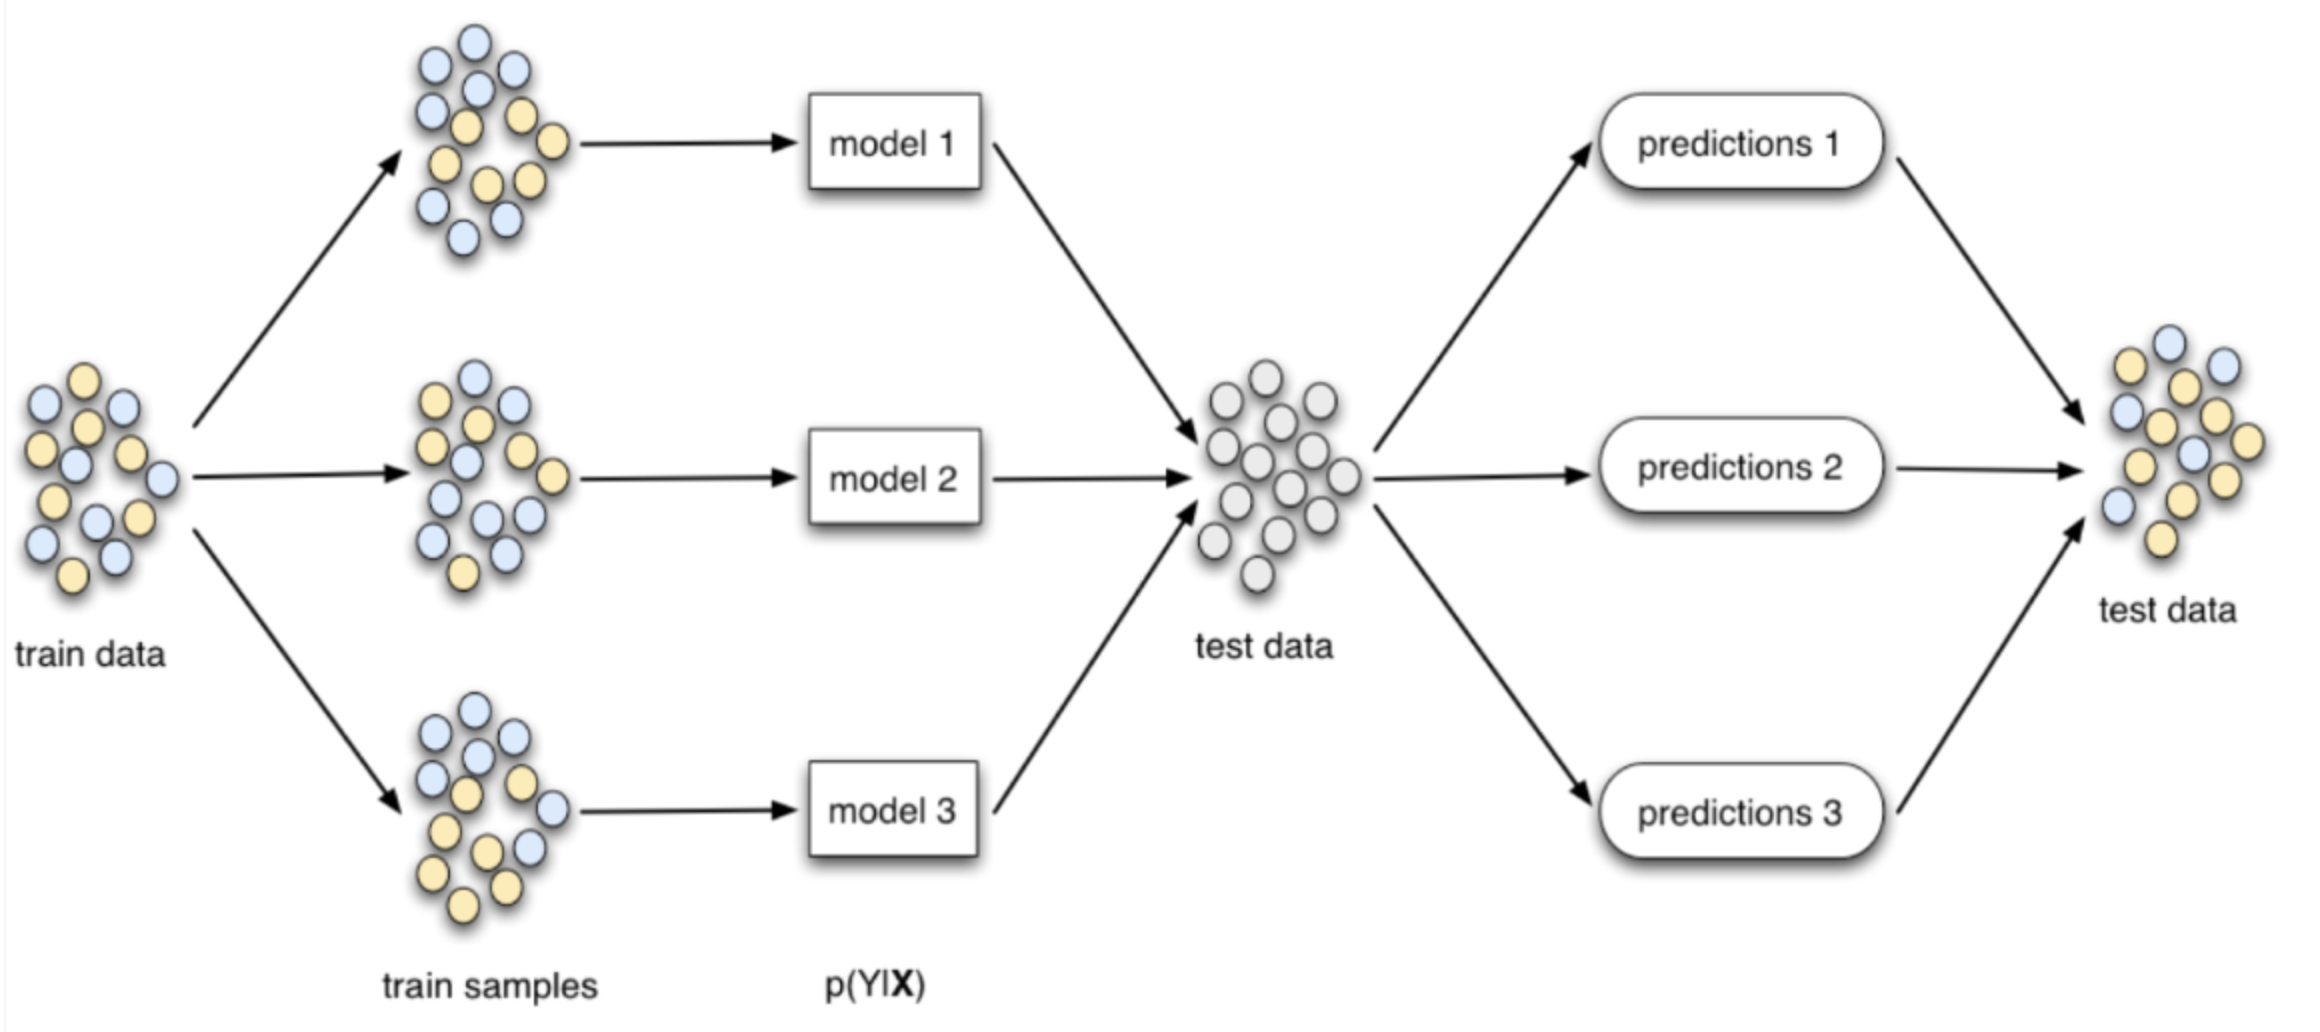

### Why Ensemble?
#### As you can find out, it is more easy to make weak classifier than one strong classifier
#### By combining many different weak classifier, those ensemble model can act like strong classifier!

###3-1. Bagging(Bootstrap aggregating)

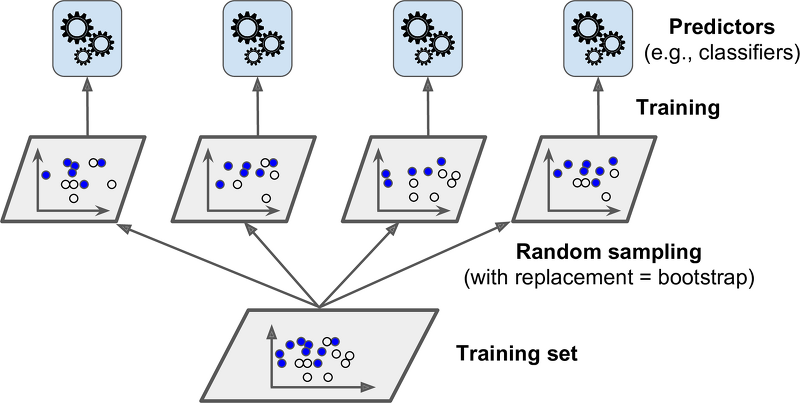

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [53]:
bagging = BaggingClassifier(tree.DecisionTreeClassifier(max_depth=4), n_estimators = 100, 
                            oob_score = True, n_jobs = -1, random_state=42, max_samples=0.3)

In [54]:
bagging.fit(train_x, train_y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=0.3, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42)

In [55]:
print(f'Number of sample: {len(bagging.estimators_samples_)}')
print(f"First model's sample: {len(bagging.estimators_samples_[0])}")
print(f"Second model's sample: {len(bagging.estimators_samples_[34])}")

Number of sample: 100
First model's sample: 186
Second model's sample: 186


In [56]:
train_acc = bagging.score(train_x, train_y)
test_acc = bagging.score(test_x, test_y)
print(f'Train Acc: {train_acc}\nTest Acc: {test_acc}')

Train Acc: 0.8571428571428571
Test Acc: 0.8022388059701493


In [57]:
result_dict['bagging'] = (train_acc, test_acc)

##3-2. Boosting(Ada boost)

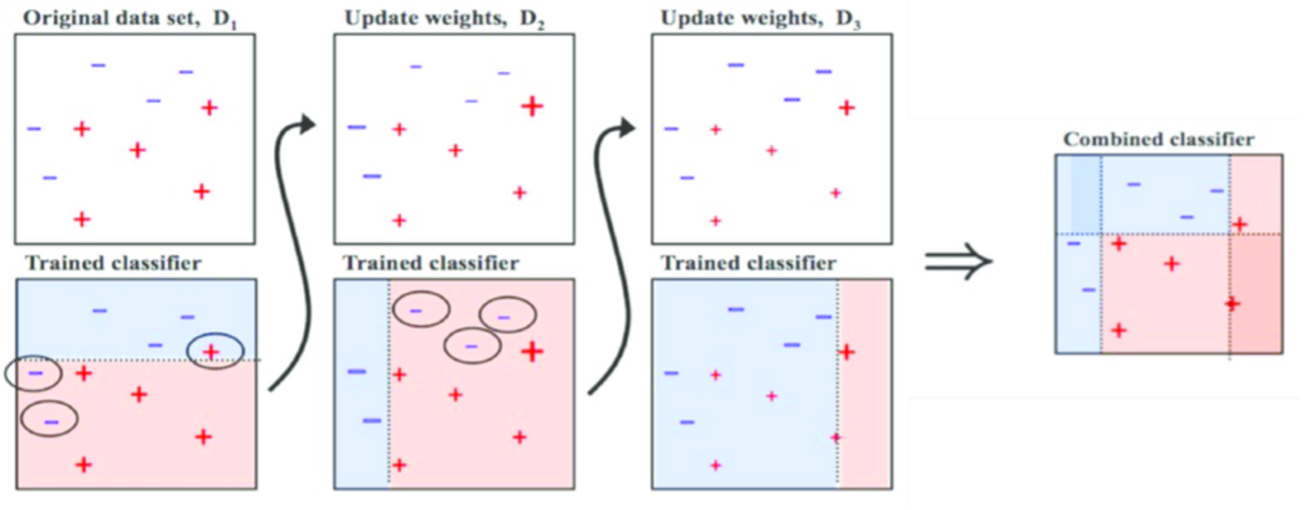

![equation of adaboost](https://imghub.insilicogen.com/media/photos/equation_adaboost.png)

![weight](https://i.postimg.cc/RVgFvZCM/2022-04-17-5-50-35.jpg)


### Weight can be calculated shown in our lecture slide

In [58]:
ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth=4),
                         n_estimators = 100,
                         random_state = 10,
                         learning_rate = 0.01,algorithm="SAMME")

In [59]:
ada.fit(train_x, train_y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.01, n_estimators=100, random_state=10)

In [60]:
train_acc = ada.score(train_x, train_y)
test_acc = ada.score(test_x, test_y)
print(f'Train Acc: {train_acc}\nTest Acc: {test_acc}')

Train Acc: 0.85553772070626
Test Acc: 0.7947761194029851


In [61]:
result_dict['ada'] = (train_acc, test_acc)

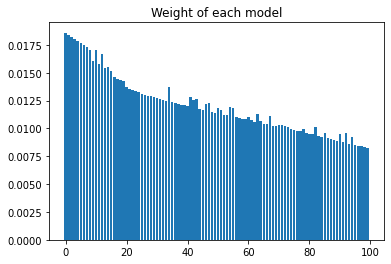

In [62]:
#model weight
plt.bar([i for i in range(len(ada.estimator_weights_))], ada.estimator_weights_)
plt.title('Weight of each model')
plt.show()

Feature importances:
[0.157 0.567 0.075 0.056 0.    0.145 0.   ]
Pclass : 0.157
Sex : 0.567
Age : 0.075
SibSp : 0.056
Parch : 0.000
Fare : 0.145
Embarked : 0.000


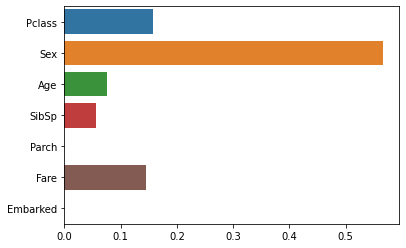

In [63]:
feature_importances(ada[0])

Feature importances:
[0.187 0.512 0.121 0.035 0.    0.136 0.01 ]
Pclass : 0.187
Sex : 0.512
Age : 0.121
SibSp : 0.035
Parch : 0.000
Fare : 0.136
Embarked : 0.010


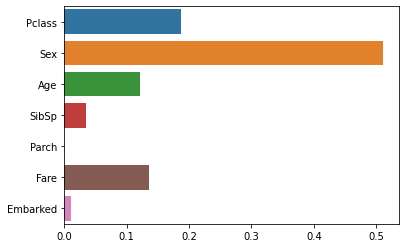

In [64]:
feature_importances(ada[20])

In [65]:
#Don't consider this code
#This is for later contents.
ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth=4),
                         n_estimators = 100,
                         random_state = 10,
                         learning_rate = 0.01,algorithm="SAMME")
ada.fit(train_x, train_y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.01, n_estimators=100, random_state=10)

###Problem 2(10pt)

Plot the acc graph of each model

Total 4 model(decision tree with no depth limint, depth limit, bagging, adaboost)

Draw the graph as similar as possible to the figure below

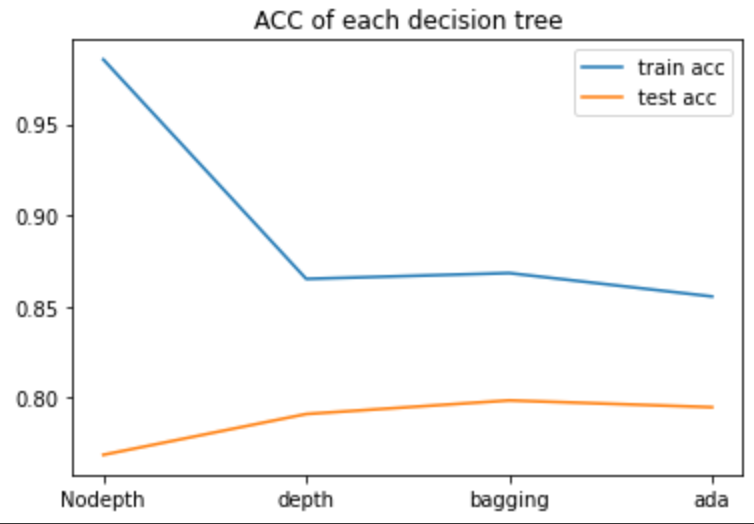

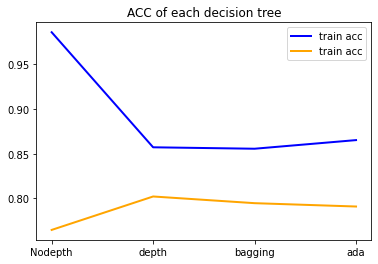

In [104]:
train_list = [i[0] for i in result_dict.values()]
test_list = [i[1] for i in result_dict.values()]

plt.plot(train_list, color="blue", label="train acc", linewidth=2)
plt.plot(test_list, color="orange", label="train acc", linewidth=2)

x = [0, 1, 2, 3]
xticks = ["Nodepth", "depth", "bagging", "ada"]
plt.xticks(x, xticks)
plt.title("ACC of each decision tree")
plt.legend()

plt.show()

### Evaluation Metrics
#### Today, we will learn about evaluation metric related with Confusion Matrix
#### Confusion Matrix is a matrix to visualize the performance of the model


![Confusion Matrix](https://miro.medium.com/max/1400/1*fxiTNIgOyvAombPJx5KGeA.png)

#### TP (True Positive) : number of predictions where the classifier predicts as positive as well their true label is also positive

#### TN (True Negative) : number of predictions where the classifier predicts as negative as well their true label is also negative
 
#### FP (False Positive) : number of predictions where the classifier predicts as positive while their true label is negative 

#### FN (False Negative) : number of predictions where the classifier predicts as negative while their true label is positive 

## Problem 3(10pt)
### Get the numeric value of TP, FP, FN and TN with the adaboost model on your own. (10 pts)
### Assume label 1 is Positive 
##### Do not use already implemented function like sklearn.metrics.confusion_matrix()

In [92]:
###answer
Predicted_values = ada.predict(test_x)
True_values = test_y.to_numpy()
TP = 0
FP = 0
FN = 0
TN = 0
#### implement by your own
for i in range(len(test_y)):
  if Predicted_values[i] == True_values[i] == 1:
    TP += 1
  elif Predicted_values[i] == 1 and True_values[i] == 0:
    FP += 1
  elif Predicted_values[i] == 0 and True_values[i] == 1:
    FN += 1
  else:
    TN += 1
####
TP, FP, FN, TN

(72, 17, 38, 141)

In [93]:
# compare your answers with function that is already implemented
# Confusion_matrix on scikit-learn is transposed with our figure
# C_(i,j) is equal to the number of observations(True Class) to be in group i and predicted to be in group j
# Our figure is opposite
from sklearn.metrics import confusion_matrix
confusion_matrix(True_values, Predicted_values, labels=[1, 0])


array([[ 72,  38],
       [ 17, 141]])

## Evaluation Metric you can calculate with Confusion Matrix
### Accuracy, Precision, Recall and F1 score.

> Accuracy: Fraction of the total samples that were correctly classified by the classifier
>> TP, TN is the well classified samples, FN, FP are misclassified samples.

>> TP+TN+FP+FN indicates all the samples!

>Precision: Fraction of predictions as a positive class were actually positive.
>> TP, FP are the samples that are predicted as positive by our classifier

>Recall: Fraction of all positive samples that are correctly predicted as positive.
>> TP, FN are the sample derived from positive samples

>F1-score: as you can find out, recall and precision are trade-off relations
Therefore, F1-score combines those 2 metrics into a single measre. It is the harmonic mean of precision and recall

![F1-score](https://miro.medium.com/max/1400/1*wUdjcIb9J9Bq6f2GvX1jSA.png)


## Problem 4(10pt)
### Implement accuracy, recall, precision and F1-score with the confusion matrix you implemented (10pts)


In [94]:
def accuracy_from_confusion_matrix(TP, FP, FN, TN):
  ##implement
  accuracy = (TP+TN)/(TP+FP+FN+TN)
  
  ###
  return accuracy

def recall_from_confusion_matrix(TP, FP, FN, TN):
  ##implement
  recall = TP/(TP+FN)

  ###
  return recall

def precision_from_confusion_matrix(TP, FP, FN, TN):
  ##implement
  precision = TP/(TP+FP)

  ###
  return precision

def F1_score_from_recall_precision(recall, precision):
  ##implement
  F1 = 2*(precision*recall)/(precision+recall)

  ###
  return F1


In [95]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
##check your answer with alreday implemented functions!

acc = accuracy_from_confusion_matrix(TP, FP, FN, TN)
recall = recall_from_confusion_matrix(TP, FP, FN, TN)
precision = precision_from_confusion_matrix(TP, FP, FN, TN)
F1 = F1_score_from_recall_precision(recall, precision)

acc_sk = accuracy_score(True_values, Predicted_values)
recall_sk = recall_score(True_values, Predicted_values)
precision_sk = precision_score(True_values, Predicted_values)
F1_sk = f1_score(True_values, Predicted_values)




print(acc, acc_sk)
print(recall, recall_sk)
print(precision, precision_sk)
print(F1, F1_sk)

0.7947761194029851 0.7947761194029851
0.6545454545454545 0.6545454545454545
0.8089887640449438 0.8089887640449438
0.7236180904522612 0.7236180904522612
